In [38]:
import cv2
import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import keras 
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Input
%matplotlib inline


In [2]:
labels_data = pd.read_csv('./datasets/train/labels.csv')

In [3]:
labels_data

,id,solution
0,0,7691845235219378648436527191763492583852169474...
1,1,7216853946839475219453128671742586392981364753...
2,2,4897521632356147897613982543178694256942753185...
3,3,2641897353517426897983562149278614538152349764...
4,4,8743162956527983413192546875278694131435728699...
...,...,...
4995,4995,5326784911895437267649213854518962733281579649...
4996,4996,8492635715761943823128756941349287562987561436...
4997,4997,5639184272417563987893425618576931421324756894...
4998,4998,6215873944576391283892145765934782618163257497...


In [4]:
labels = labels_data['solution'].to_list()

In [5]:
img_path = 'datasets/train/images/'

In [6]:
img_names = os.listdir(img_path)

In [7]:
img_names.sort()
print(img_names)

['0000.png', '0001.png', '0002.png', '0003.png', '0004.png', '0005.png', '0006.png', '0007.png', '0008.png', '0009.png', '0010.png', '0011.png', '0012.png', '0013.png', '0014.png', '0015.png', '0016.png', '0017.png', '0018.png', '0019.png', '0020.png', '0021.png', '0022.png', '0023.png', '0024.png', '0025.png', '0026.png', '0027.png', '0028.png', '0029.png', '0030.png', '0031.png', '0032.png', '0033.png', '0034.png', '0035.png', '0036.png', '0037.png', '0038.png', '0039.png', '0040.png', '0041.png', '0042.png', '0043.png', '0044.png', '0045.png', '0046.png', '0047.png', '0048.png', '0049.png', '0050.png', '0051.png', '0052.png', '0053.png', '0054.png', '0055.png', '0056.png', '0057.png', '0058.png', '0059.png', '0060.png', '0061.png', '0062.png', '0063.png', '0064.png', '0065.png', '0066.png', '0067.png', '0068.png', '0069.png', '0070.png', '0071.png', '0072.png', '0073.png', '0074.png', '0075.png', '0076.png', '0077.png', '0078.png', '0079.png', '0080.png', '0081.png', '0082.png', '00

In [89]:
def trans(img):
    
    img1 = np.zeros([img.shape[0]+10,img.shape[1]+10])
    img1[5:img1.shape[0]-5,5:img1.shape[1]-5] = img
    ret, thresh = cv2.threshold(img1, 120, 255, cv2.THRESH_BINARY)
    
    coords = np.column_stack(np.where(thresh > 0))
    angle = cv2.minAreaRect(coords)[-1]
    if angle < -45:
        angle = angle + 90
    M = cv2.getRotationMatrix2D((thresh.shape[0] / 2, thresh.shape[1] / 2), -angle, 1) 
    img1 = cv2.warpAffine(thresh, M, (thresh.shape[0], thresh.shape[1])) 
    ret, img1 = cv2.threshold(img1, 120, 255, cv2.THRESH_BINARY)
    
    coor = np.where(img1 > 0)
    x_min = np.min(coor[0])
    y_min = np.min(coor[1])
    
    img1 = img1[x_min:,y_min:]
    img1 = img1[:img1.shape[0]-x_min,:img1.shape[1]-y_min]
    
    x_left = img1.shape[0]%9
    y_left = img1.shape[1]%9
    
    img1 = img1[x_left:,y_left:]
    
    img1 = cv2.resize(img1, (306, 306),interpolation = cv2.INTER_NEAREST)
    blurred = cv2.GaussianBlur(img1, (7, 7), 3)
    ret, img1 = cv2.threshold(img1, 120, 255, cv2.THRESH_BINARY)
    img1 = 255 - img1
    return img1

In [9]:
def get_train_set():
    global img_names
    global img_path
    X = {}
    for i in range(len(img_names)):
        filepath = img_path + img_names[i]
        img = cv2.imread(filepath)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img1 = trans(img)
        X[i] = img1
        if(i % 1000 == 0):
            print(i)
    
    return X

In [113]:
def step(img,label):
    
    s = int(img.shape[0]/9)
    print(s,img.shape,300/9)
    X = []
    Y = []
    for i in range(9):
        for j in range(9):
            img1 = img[s*i:s*(i+1),j*s:(j+1)*s]
            
            cur = i*9 + j
            label1 = label[cur]
            
            img1 = img1[4:,4:]
            img1 = img1[:img1.shape[0]-5,:img1.shape[1]-5]
            ret, img1 = cv2.threshold(img1, 120, 255, cv2.THRESH_BINARY)
            if np.count_nonzero(img1 == 255) / (img1.shape[0]*img1.shape[1]) < 0.03:
                label1 = -1
            
            X.append(img1)
            Y.append(int(label1))
    
    return X,Y

In [75]:
def classify():
    
    (X_train, y_train), (X_test, y_test) = mnist.load_data()
    print(X_train.shape)
    X_train = X_train.reshape((X_train.shape[0], 28, 28, 1))
    X_test = X_test.reshape((X_test.shape[0], 28, 28, 1))
    X_train = np.array(X_train, dtype=np.float64)
    X_test = np.array(X_test, dtype=np.float64)
    X_train /= 255
    X_test /= 255
    
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',input_shape=(28, 28, 1))) #image size
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax')) #number of classes
    model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    batch_size = 128
    epochs = 3
    model.load_weights('./model_weights')
#     model.fit(X_train, y_train,batch_size=batch_size,epochs=epochs,verbose=2,validation_data=(X_test, y_test))
    score = model.evaluate(X_test, y_test, verbose=1)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    
    return model

In [47]:
def classify_1(X_train,y_train):
    
    X_train = X_train.reshape((X_train.shape[0], 25, 25, 1))
    X_train = np.array(X_train, dtype=np.float64)
    X_train /= 255
    
    n = X_train.shape[0]
    
    X_test = X_train[int(0.8*n):,:,:,:]
    X_train = X_train[:int(0.8*n),:,:,:]
    y_test = y_train[int(0.8*n):]
    y_train = y_train[:int(0.8*n)]
    print(X_train.shape,X_test.shape)
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',input_shape=(28, 28, 1))) #image size
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax')) #number of classes
    model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    batch_size = 128
    epochs = 3
    model.fit(X_train, y_train,batch_size=batch_size,epochs=epochs,verbose=2)
    score = model.evaluate(X_train, y_train, verbose=1)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    
    return model

In [90]:
images_X = get_train_set()

0
1000
2000
3000
4000


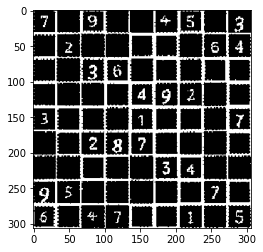

In [114]:
plt.imshow(images_X[0],'Greys_r')

In [115]:
print(labels[0])

769184523521937864843652719176349258385216947492875631217593486958461372634728195


In [93]:
model = classify()

(60000, 28, 28)
10000/10000 [==============================] - 7s 680us/step
Test loss: 0.036483276467087856
Test accuracy: 0.9882000088691711


In [31]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_test = X_test.reshape((X_test.shape[0], 28, 28, 1))
X_test = np.array(X_test, dtype=np.float64)
X_test /= 255
print(X_test.shape)
print(model.predict(X_test[0].reshape(1,28,28,1)))
digits_0,labels_0 = step(images_X[0],labels[0])
img1 = digits_0[0]
img1 = cv2.resize(img1, (28, 28),interpolation = cv2.INTER_NEAREST)
img1 = img1.reshape(1,28,28,1)
img1 = img1/255

print(img1.shape)
print(np.argmax(model.predict(img1)))

(10000, 28, 28, 1)
[[8.4714119e-12 2.5068997e-10 1.3041849e-09 1.5412067e-07 5.3511695e-10
  1.6561426e-12 3.7239936e-14 9.9999976e-01 1.4756479e-11 1.6118993e-07]]
34 (306, 306) 33.333333333333336
(1, 28, 28, 1)
7


In [116]:
digits_0,labels_0 = step(images_X[0],labels[0])

34 (306, 306) 33.333333333333336


In [118]:
labels_1 = np.array(labels_0)
labels_1[labels_1 != -1] = 1
labels_1[labels_1 == -1] = 0
print(np.sum(labels_1))

29


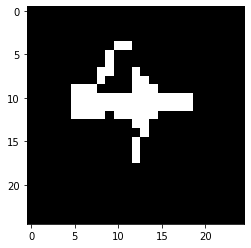

In [95]:
plt.imshow(digits_0[5],'Greys_r')

In [106]:
print(digits_0[3].shape)

img1 = cv2.resize(digits_0[2], (28, 28),interpolation = cv2.INTER_NEAREST)

(25, 25)


255.0


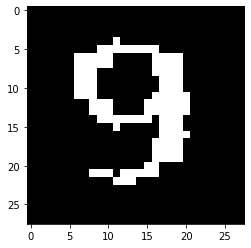

In [107]:
plt.imshow(img1,'Greys_r')

print(img1.max())

In [112]:
print(labels_0[2])

9


In [110]:
img1 = img1.reshape(1,28,28,1)
img1 = (255-img1)/255

y_hat = model.predict(img1)
print(np.argmax(y_hat),labels_0[2])

6 9


34 (306, 306) 33.333333333333336
7 7


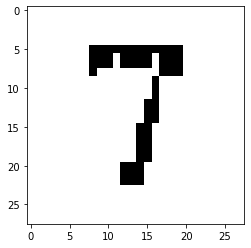

2 9


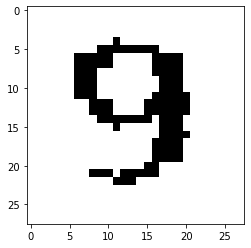

8 4


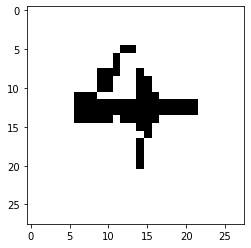

8 5


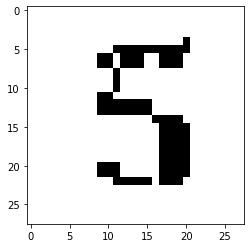

8 3


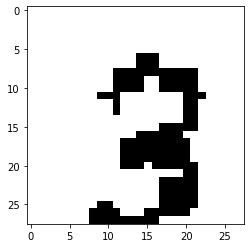

8 2


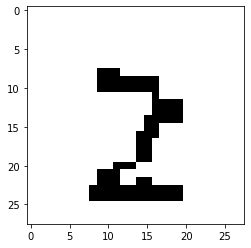

8 6


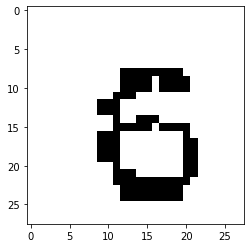

4 4


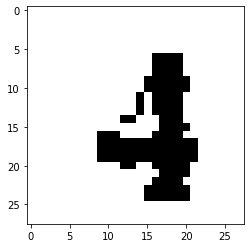

0 3


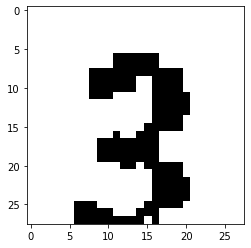

8 6


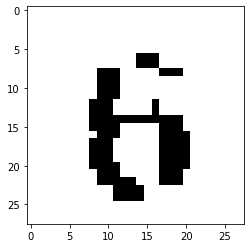

0 4


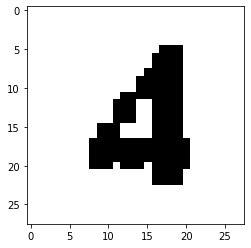

3 9


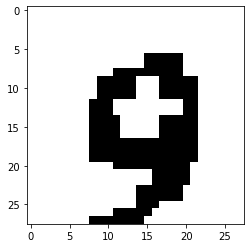

8 2


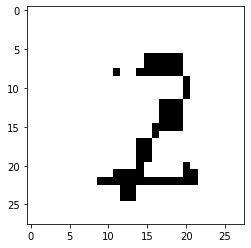

8 3


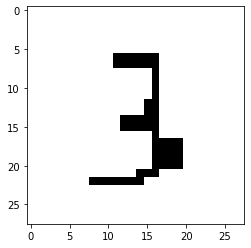

8 1


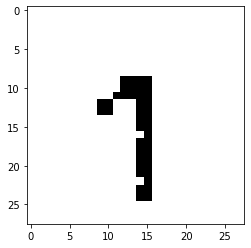

5 7


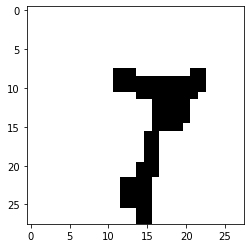

2 2


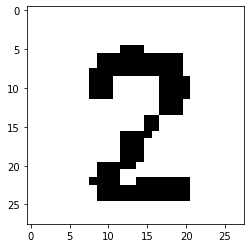

9 8


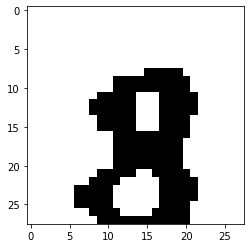

7 7


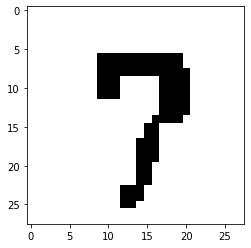

8 3


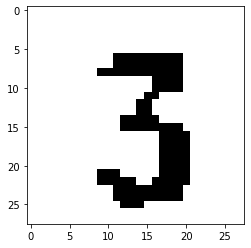

0 4


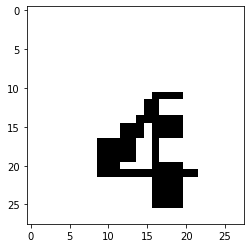

5 9


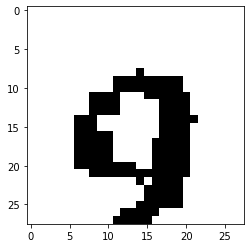

8 5


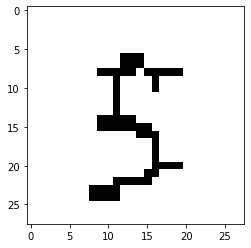

7 7


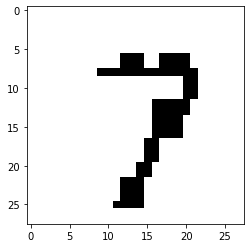

3 6


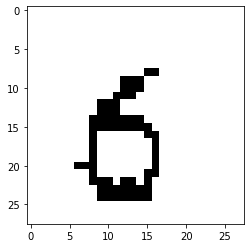

8 4


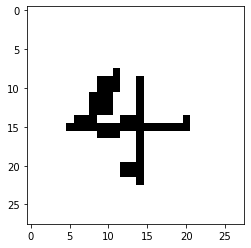

8 7


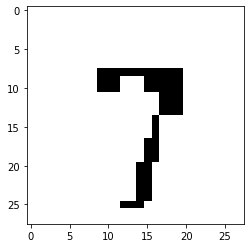

8 1


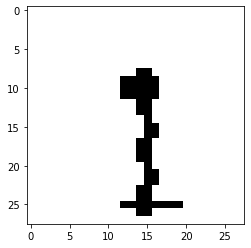

8 5


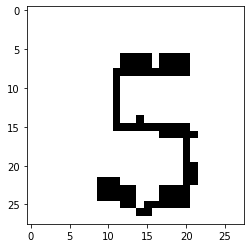

In [50]:
digits_0,labels_0 = step(images_X[0],labels[0])
X_train = np.zeros((81*len(digits_0),28,28))
y_train = np.zeros((81*len(digits_0)))
sh = digits_0[0].shape
cur = 0
for i in range(81):
    img1 = digits_0[i]
    img1 = cv2.resize(img1, (28, 28),interpolation = cv2.INTER_NEAREST)
    X_train[cur,:,:] = img1
    y_train[cur] = labels_0[i]
    cur = cur+1
    img1 = img1.reshape(1,28,28,1)
    img1 = img1/255
    if(labels_0[i] != -1):
        y_hat = model.predict(img1)
        print(np.argmax(y_hat),labels_0[i])
        plt.imshow(img1.reshape(28,28),'Greys_r')
        
#         print(i)

    
#     print(labels_0[i])
    plt.show()

In [48]:
y_train[y_train == -1] = 0
m = classify_1(X_train,y_train)

(5248, 28, 28, 1) (1313, 28, 28, 1)
Epoch 1/3
 - 4s - loss: 0.7758 - accuracy: 0.9929
Epoch 2/3
 - 4s - loss: 0.0271 - accuracy: 0.9943
Epoch 3/3
 - 5s - loss: 0.0168 - accuracy: 0.9956
5248/5248 [==============================] - 1s 234us/step
Test loss: 0.01110870681884812
Test accuracy: 0.9961889982223511


34 (306, 306) 33.333333333333336
7 7


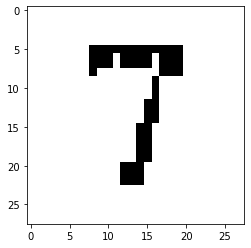

7 9


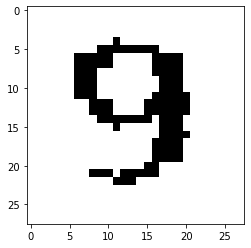

0 4


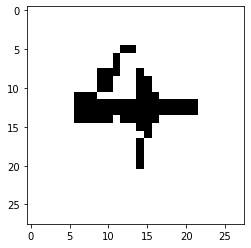

7 5


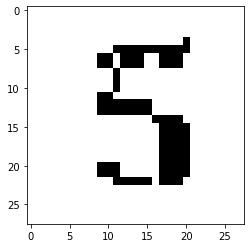

7 3


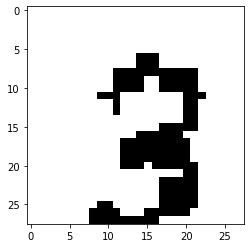

7 2


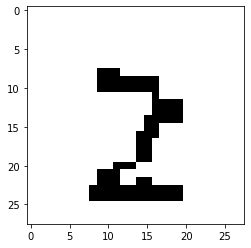

7 6


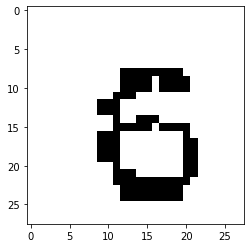

4 4


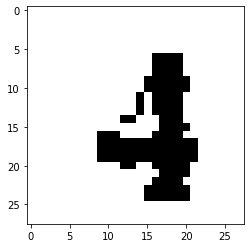

7 3


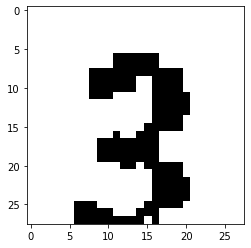

7 6


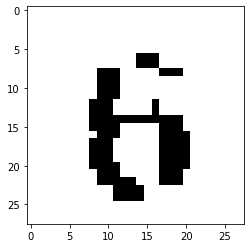

4 4


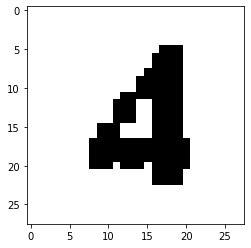

7 9


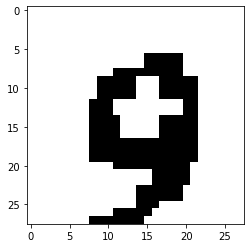

7 2


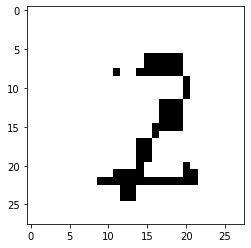

7 3


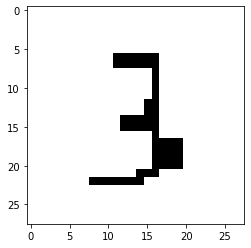

0 1


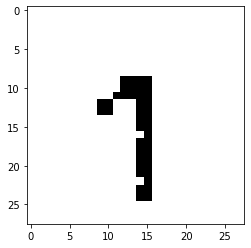

7 7


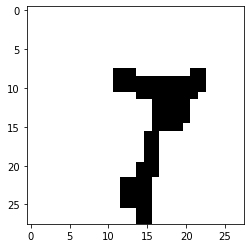

7 2


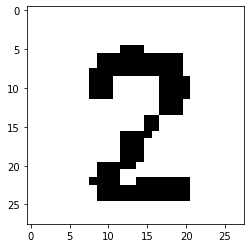

4 8


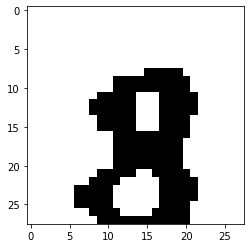

7 7


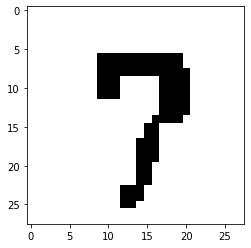

7 3


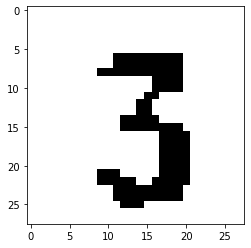

4 4


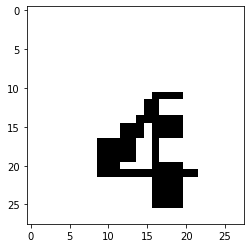

4 9


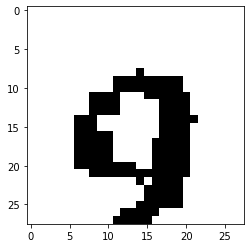

7 5


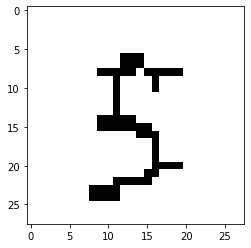

7 7


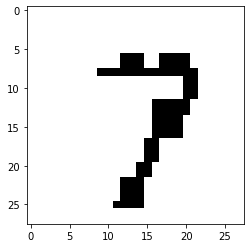

0 6


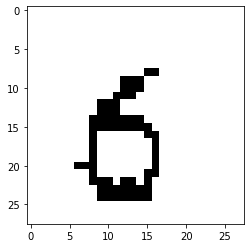

4 4


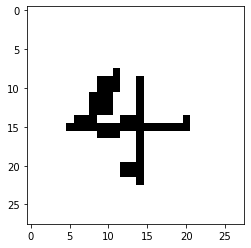

7 7


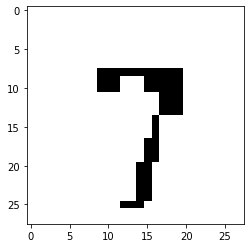

0 1


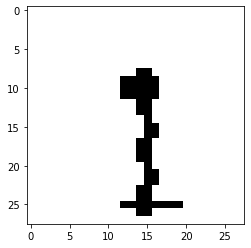

7 5


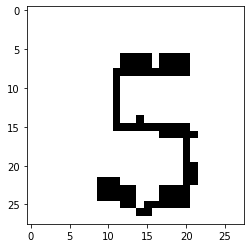

In [49]:
digits_0,labels_0 = step(images_X[0],labels[0])
sh = digits_0[0].shape
cur = 0
for i in range(81):
    img1 = digits_0[i]
    img1 = cv2.resize(img1, (28, 28),interpolation = cv2.INTER_NEAREST)
    cur = cur+1
    img1 = img1.reshape(1,28,28,1)
    img1 = img1/255
    if(labels_0[i] != -1):
        y_hat = m.predict(img1)
        print(np.argmax(y_hat),labels_0[i])
        plt.imshow(img1.reshape(28,28),'Greys_r')
        
#         print(i)

    
#     print(labels_0[i])
    plt.show()

In [26]:
labels_1 = np.array(labels_0)
labels_1[labels_1 != -1] = 1
labels_1[labels_1 == -1] = 0

In [28]:
print(labels_0)
print(np.sum(labels_1))

[7, -1, 9, -1, -1, 4, 5, -1, 3, -1, 2, -1, -1, -1, -1, -1, 6, 4, -1, -1, 3, 6, -1, -1, -1, -1, -1, -1, -1, -1, -1, 4, 9, 2, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 7, -1, -1, 2, 8, 7, -1, -1, -1, -1, -1, -1, -1, -1, -1, 3, 4, -1, -1, 9, 5, -1, -1, -1, -1, -1, 7, -1, 6, -1, -1, -1, -1, -1, -1, -1, 5]
24


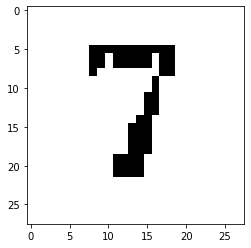

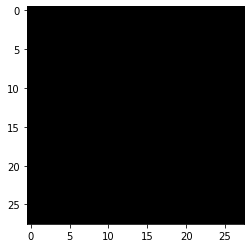

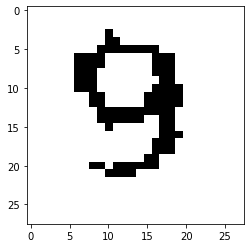

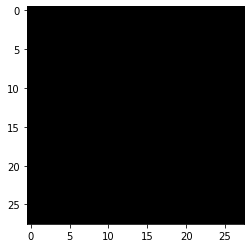

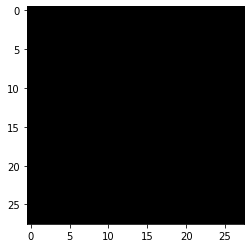

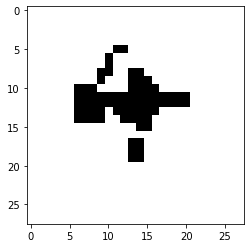

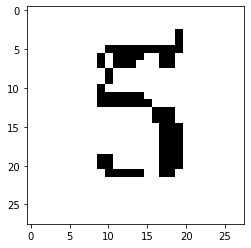

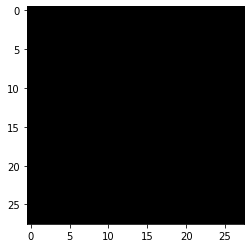

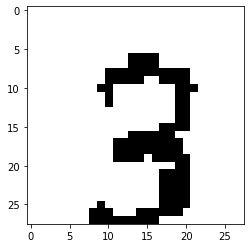

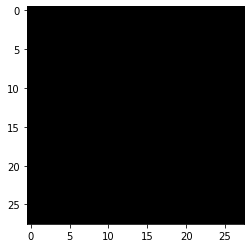

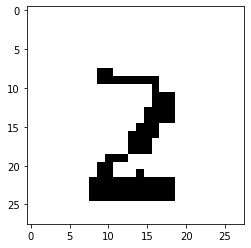

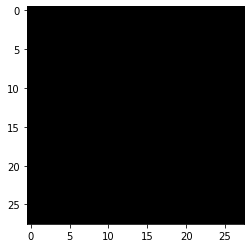

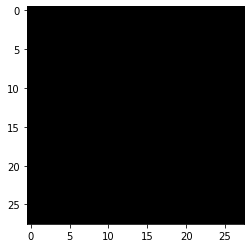

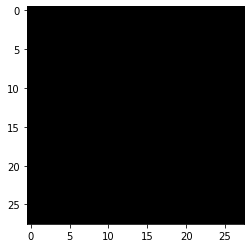

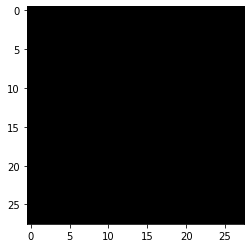

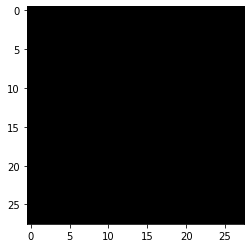

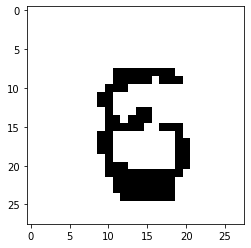

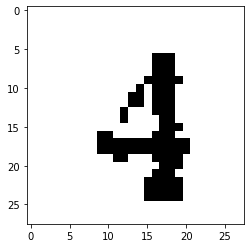

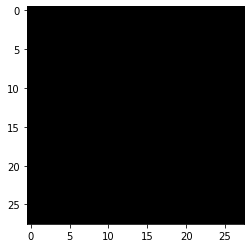

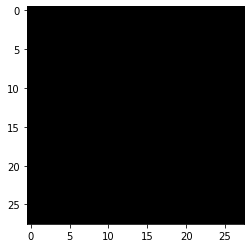

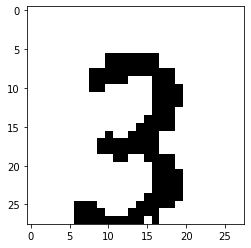

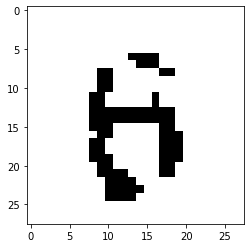

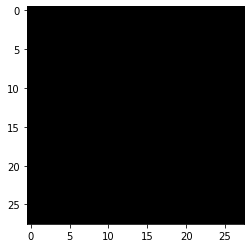

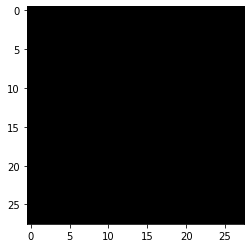

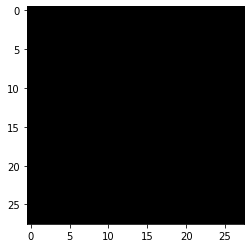

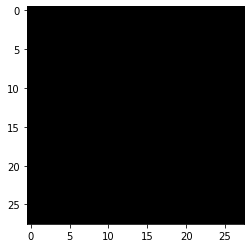

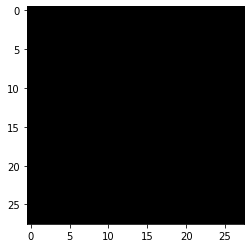

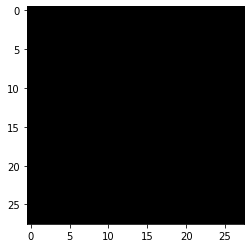

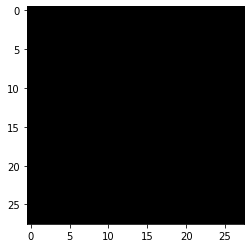

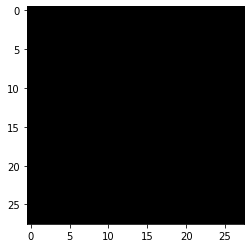

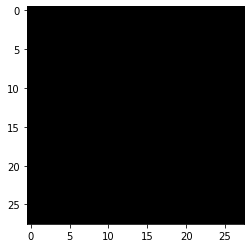

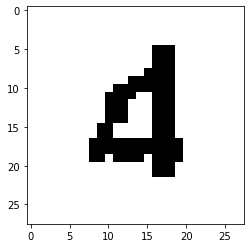

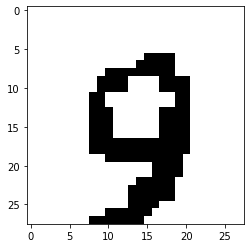

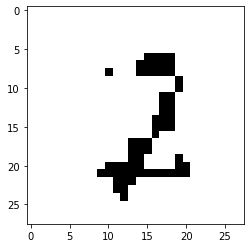

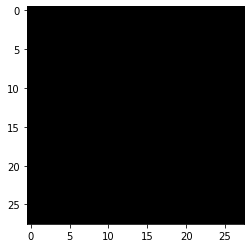

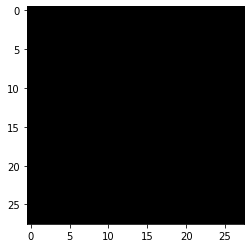

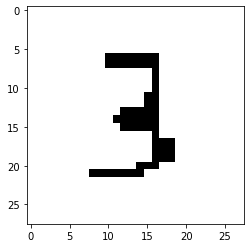

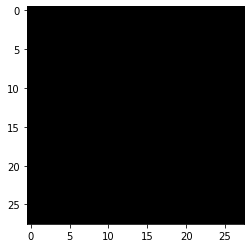

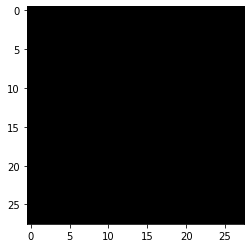

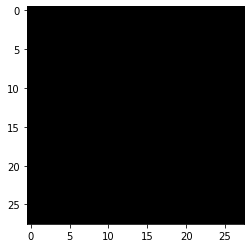

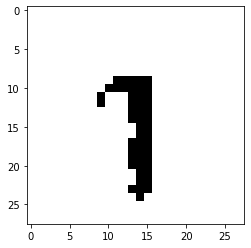

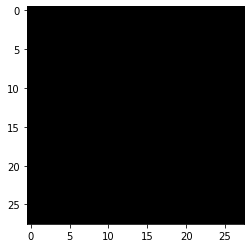

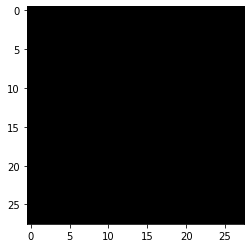

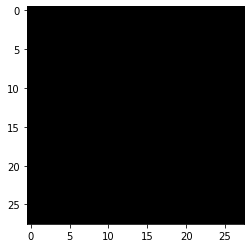

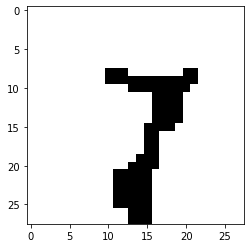

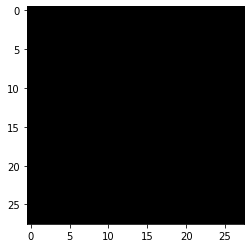

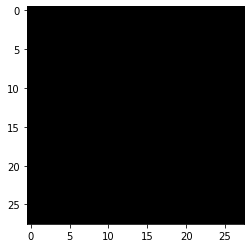

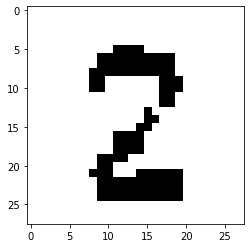

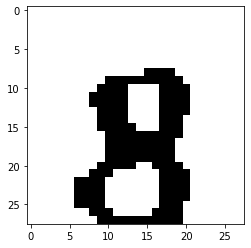

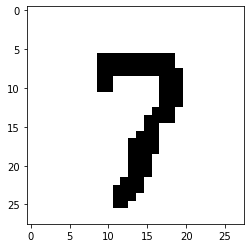

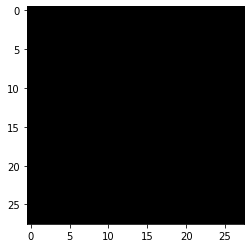

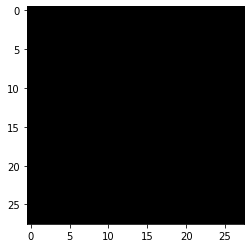

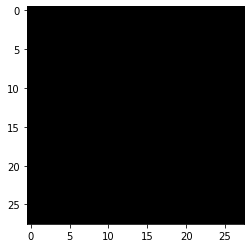

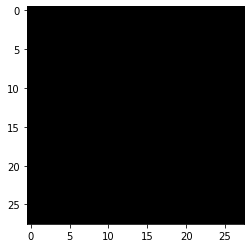

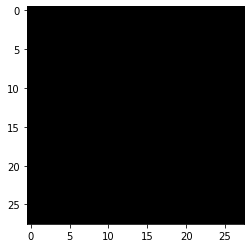

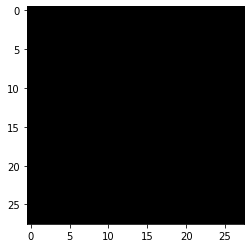

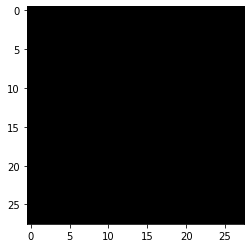

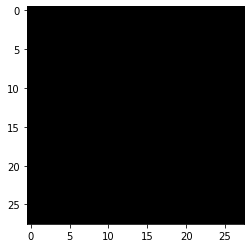

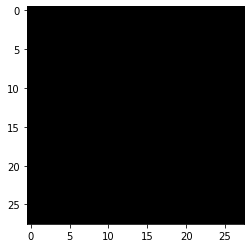

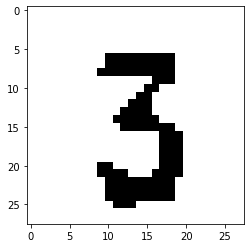

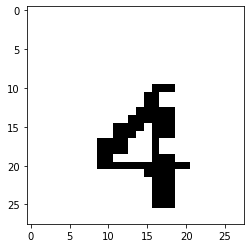

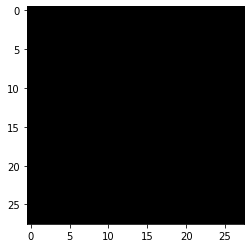

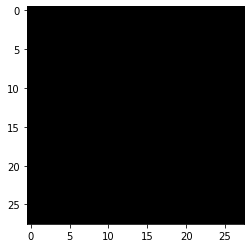

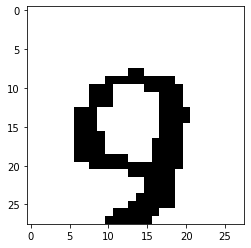

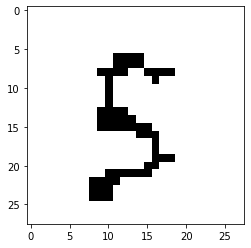

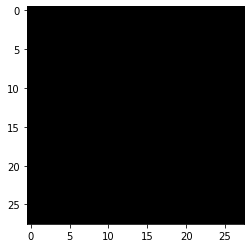

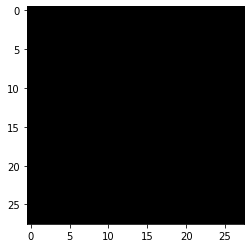

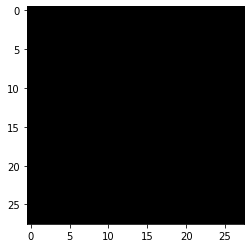

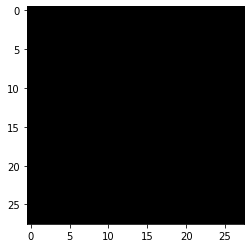

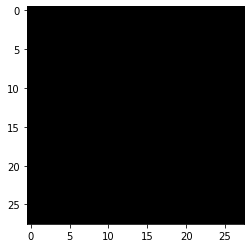

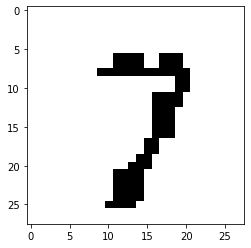

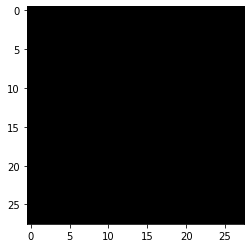

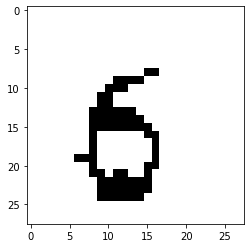

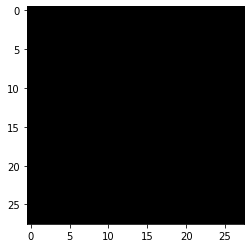

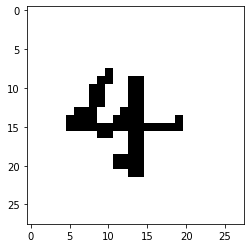

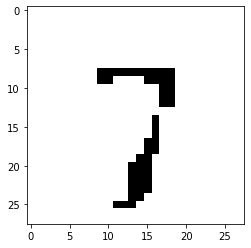

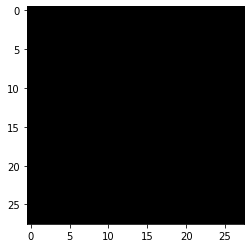

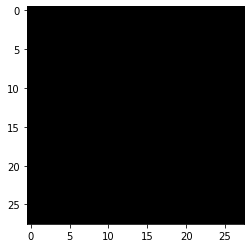

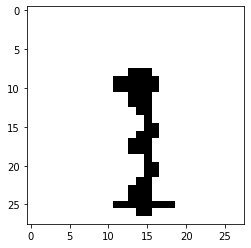

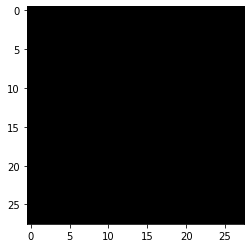

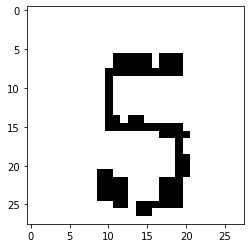

In [17]:
data_x = np.zeros((24,28,28,1))
for i in range (81):
    img1 = digits_0[i]
    (m,n) = digits_0[i].shape
    bigger = cv2.resize(img1, (28*n, 28*m))
    img1 = cv2.resize(bigger, (0, 0), fx = 1/m, fy = 1/n)
    ret, img1 = cv2.threshold(img1, 120, 255, cv2.THRESH_BINARY)
    img1 = img1.reshape(28,28,1)
    data_x[i,:,:,:] = img1
    plt.imshow(img1,cmap='Greys_r')
    plt.show()
#     model.predict(img1)

In [17]:
model.predict_proba(data_x)

array([[2.0716407e-21, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 9.9919134e-24, 0.0000000e+00,
        1.0000000e+00, 0.0000000e+00],
       [2.0716407e-21, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 9.9919134e-24, 0.0000000e+00,
        1.0000000e+00, 0.0000000e+00],
       [2.0716407e-21, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 9.9919134e-24, 0.0000000e+00,
        1.0000000e+00, 0.0000000e+00],
       [2.0716407e-21, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 9.9919134e-24, 0.0000000e+00,
        1.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        1.0000000e+00, 0.0000000e+00],
       [2.9046435e-08, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.00

In [21]:
coords = np.column_stack(np.where(thresh > 0))
angle = cv2.minAreaRect(coords)[-1]
if angle < -45:
    angle = angle + 90
    angle = -angle
print(angle)

-12.094757080078125


In [22]:
M = cv2.getRotationMatrix2D((thresh.shape[0] / 2, thresh.shape[1] / 2), -angle, 1) 
img1 = cv2.warpAffine(thresh, M, (thresh.shape[0], thresh.shape[1])) 
ret, img1 = cv2.threshold(img1, 120, 255, cv2.THRESH_BINARY)

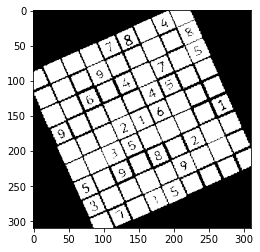

In [23]:
plt.imshow(img1,cmap='Greys_r')
plt.show()